# Data loader and generation of the model

In this notebook you can first download and modify the data such that it is in the right format for the model training. It is saved in a compressed .npz file. Then you can create the model architecture and finally can train it.

It is separated in 4 parts:
- The intro (here)
- The Data Loader
- The Model Creation
- The Model Training

For more informations about the model and the different parts, you can check our report in the same github.

This notebook is mainly taken from the tutorial on how to design and train a Pix2Pix conditional GA that you can find here: 
https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

Further informations and test made with the same architecture can be found in the paper:
https://arxiv.org/abs/1611.07004


**Note 1:** If you already loaded and compressed the data into a .npz file, you can skip the data_loader part. It is quite time consuming for big dataset and you don't need to redo it. 

**Note 2:** It is also important to note that with big dataset, a lot of RAM is consumed. It is because you actually load two time the data, one in the data_loader and one in the Model Training. The tips is to run the Data Loader part first, then restart execution time, and finally skip the Data Loader part and go to the Model definition (you can run everything from ther)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Move to the spacewarp project

In [2]:
%cd gdrive
%cd MyDrive

/content/gdrive
/content/gdrive/MyDrive


In [3]:

%cd Epfl
%cd spacewarp

/content/gdrive/MyDrive/Epfl
/content/gdrive/MyDrive/Epfl/spacewarp


# Data Loader

We select the data and load them into 2 arrays. Then we create a compress numpy file with it

In [4]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path_in, path_out, size=(512,512)):
 origin_list, transf_list = list(), list()
 # we sort the directories, important to do when using drive
 sorted_in = sorted(listdir(path_in))
 sorted_out = sorted(listdir(path_out))
 # enumerate filenames in directory, assume all are images
 for filename in sorted_in:
  # load and resize the image
  pixels = load_img(path_in + filename, target_size=size)
  # convert to numpy array
  origin_img = img_to_array(pixels)
  origin_list.append(origin_img)

 for filename in sorted_out:
  # load and resize the image
  pixels = load_img(path_out + filename, target_size=size)
  # convert to numpy array
  transf_img = img_to_array(pixels)
  transf_list.append(transf_img)

 return [asarray(origin_list), asarray(transf_list)]

We test it

In [ ]:
#unzip if necessary
!unzip "Data/Cosmic_135_mirror/clear_front_in_mirror.zip" -d "Data/Cosmic_135_mirror/"

In [ ]:
#unzip if necessary
!unzip "Data/Cosmic_135_mirror/clear_front_out_mirror.zip" -d "Data/Cosmic_135_mirror/"

In [48]:
# dataset path
path_in = 'Data/Cosmic_135_mirror/clear_front_in_mirror/'
path_out = 'Data/Cosmic_135_mirror/clear_front_out_mirror/'
# load dataset
[src_images, tar_images] = load_images(path_in, path_out)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'Data/Cosmic_135_mirror/135images_mirror_512.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (270, 512, 512, 3) (270, 512, 512, 3)
Saved dataset:  Data/Cosmic_135_mirror/135images_mirror_512.npz


Visualization:

We note that the images do not have seemingly the same shape. It is because while filtering them, we added padding to make them all squares without having to distort them

Loaded:  (135, 512, 512, 3) (135, 512, 512, 3)


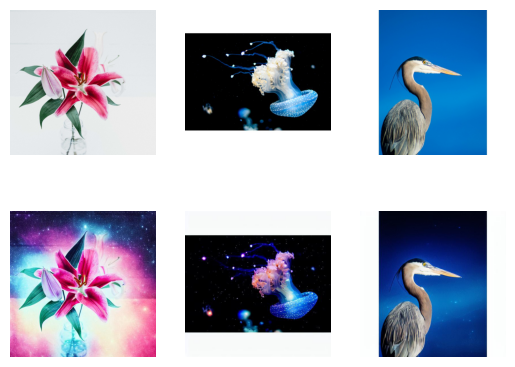

In [49]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
filename = 'Data/Cosmic_135/135images_512.npz'
# load the dataset
data = load(filename)
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

#Model Creation

Check you are using the GPU in your colab/device, otherwise the training times is more than tenfold what you could have! 

Here we test it quickly:

We have a GAN which is composed of a discriminator and a generator. The generator goal is to create a new transformation of the image that is accepted by the generator. The discriminator wants to be able to know if it is a real transformation (from dataset) or one created by the generator.

They play this game such that they "train" each other.

In [6]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

## The discriminator

In [7]:
# define the discriminator model
def define_discriminator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # source image input
 in_src_image = Input(shape=image_shape)
 # target image input
 in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

## Generator

A classical U-net

In [8]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # add downsampling layer
 g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # conditionally add batch normalization
 if batchnorm:
   g = BatchNormalization()(g, training=True)
 # leaky relu activation
 g = LeakyReLU(alpha=0.2)(g)
 return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # add upsampling layer
 g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # add batch normalization
 g = BatchNormalization()(g, training=True)
 # conditionally add dropout
 if dropout:
   g = Dropout(0.5)(g, training=True)
 
 # merge with skip connection
 g = Concatenate()([g, skip_in])
 # relu activation
 g = Activation('relu')(g)
 return g

And now we create the U-net with the blocks:

In [9]:
# define the standalone generator model
def define_generator(image_shape=(512,512,3)):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # image input
 in_image = Input(shape=image_shape)
 # encoder model
 e1 = define_encoder_block(in_image, 64, batchnorm=False)
 e2 = define_encoder_block(e1, 128)
 e3 = define_encoder_block(e2, 256)
 e4 = define_encoder_block(e3, 512)
 e5 = define_encoder_block(e4, 512)
 e6 = define_encoder_block(e5, 512)
 e7 = define_encoder_block(e6, 512)
 # bottleneck, no batch norm and relu
 b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
 b = Activation('relu')(b)
 # decoder model
 d1 = decoder_block(b, e7, 512)
 d2 = decoder_block(d1, e6, 512)
 d3 = decoder_block(d2, e5, 512)
 d4 = decoder_block(d3, e4, 512, dropout=False)
 d5 = decoder_block(d4, e3, 256, dropout=False)
 d6 = decoder_block(d5, e2, 128, dropout=False)
 d7 = decoder_block(d6, e1, 64, dropout=False)
 # output
 g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
 out_image = Activation('tanh')(g)
 # define model
 model = Model(in_image, out_image)
 return model

## GAN

now we put the two together to get our GAN:

In [10]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
 # make weights in the discriminator not trainable
 for layer in d_model.layers:
   if not isinstance(layer, BatchNormalization):
     layer.trainable = False
   # define the source image
   in_src = Input(shape=image_shape)
   # connect the source image to the generator input
   gen_out = g_model(in_src)
   # connect the source input and generator output to the discriminator input
   dis_out = d_model([in_src, gen_out])
   # src image as input, generated image and classification output
 model = Model(in_src, [dis_out, gen_out])
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 return model

Putting it together

In [11]:
# load and prepare training images
def load_real_samples(filename):
 # load compressed arrays
 data = load(filename)
 # unpack arrays
 X1, X2 = data['arr_0'], data['arr_1']
 # scale from [0,255] to [-1,1]
 X1 = (X1 - 127.5) / 127.5
 X2 = (X2 - 127.5) / 127.5
 return [X1, X2]

Then take care of the generation of real and fake samples, that we use for visualisation in the Summarize_training phase. It will plot two real samples and a fake one, and for each plot:
- the source image
- the generated image
- the expected image

It saves the plot and saves the model

In [12]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
 # unpack dataset
 trainA, trainB = dataset
 # choose random instances
 ix = randint(0, trainA.shape[0], n_samples)
 # retrieve selected images
 X1, X2 = trainA[ix], trainB[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, patch_shape, patch_shape, 1))
 return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
 # generate fake instance
 X = g_model.predict(samples)
 # create 'fake' class labels (0)
 y = zeros((len(X), patch_shape, patch_shape, 1))
 return X, y

 # generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
 # select a sample of input images
 [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
 # generate a batch of fake samples
 X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 # scale all pixels from [-1,1] to [0,1]
 X_realA = (X_realA + 1) / 2.0
 X_realB = (X_realB + 1) / 2.0
 X_fakeB = (X_fakeB + 1) / 2.0
 # plot real source images
 for i in range(n_samples):
   pyplot.subplot(3, n_samples, 1 + i)
   pyplot.axis('off')
   pyplot.imshow(X_realA[i])
   
 # plot generated target image
 for i in range(n_samples):
   pyplot.subplot(3, n_samples, 1 + n_samples + i)
   pyplot.axis('off')
   pyplot.imshow(X_fakeB[i])
 
 # plot real target image
 for i in range(n_samples):
   pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
   pyplot.axis('off')
   pyplot.imshow(X_realB[i])
 
 # save plot to file
 filename1 = 'plot_%06d.png' % (step+1)
 pyplot.savefig(filename1)
 pyplot.close()
 # save the generator model
 filename2 = 'model_%06d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))

#  Model Training

train the models and save the advancement every 10% of the work made. It is a checkpoint such that you do not lose every advancement of your training phase.

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
 # determine the output square shape of the discriminator
 n_patch = d_model.output_shape[1]
 # unpack dataset
 trainA, trainB = dataset
 # calculate the number of batches per training epoch
 bat_per_epo = int(len(trainA) / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 # manually enumerate epochs
 for i in range(n_steps):
   # select a batch of real samples
   [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
   # generate a batch of fake samples
   X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
   # update discriminator for real samples
   d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
   # update discriminator for generated samples
   d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
   # update the generator
   g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
   # summarize performance
   print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
   # summarize model performance
   if (i+1) % (bat_per_epo * 10) == 0:
     summarize_performance(i, g_model, dataset)
 

we can train now n images for m epochs for a total of n*m steps

In [14]:
#CONSTANTS (CHANGE FOR EACH TYPE OF RUN)
FILENAME = 'Data/Cosmic_135_mirror/135images_mirror_512.npz'
N_EPOCH = 60

In [15]:
# load image data
dataset = load_real_samples(FILENAME)
print('Loaded', dataset[0].shape, dataset[1].shape)

# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset, N_EPOCH)

Loaded (270, 512, 512, 3) (270, 512, 512, 3)


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 24ms/step
>202, d1[0.356] d2[0.189] g[23.807]
1/1 [==============================] - 0s 25ms/step
>203, d1[0.272] d2[0.150] g[18.155]
1/1 [==============================] - 0s 23ms/step
>204, d1[0.264] d2[0.355] g[29.207]
1/1 [==============================] - 0s 24ms/step
>205, d1[0.138] d2[0.180] g[15.396]
1/1 [==============================] - 0s 23ms/step
>206, d1[0.625] d2[0.363] g[13.735]
1/1 [==============================] - 0s 25ms/step
>207, d1[0.153] d2[0.416] g[18.475]
1/1 [==============================] - 0s 24ms/step
>208, d1[0.424] d2[0.170] g[21.892]
1/1 [==============================] - 0s 24ms/step
>209, d1[0.213] d2[0.413] g[14.397]
1/1 [==============================] - 0s 26ms/step
>210, d1[0.172] d2[0.171] g[13.131]
1/1 [==============================] - 0s 25ms/step
>211, d1[0.437] d2[0.159] g[20.740]
1/1 [==============================] - 0s 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 23ms/step
>2902, d1[0.289] d2[0.301] g[9.441]
1/1 [==============================] - 0s 23ms/step
>2903, d1[0.393] d2[0.382] g[8.229]
1/1 [==============================] - 0s 24ms/step
>2904, d1[0.471] d2[0.316] g[8.653]
1/1 [==============================] - 0s 24ms/step
>2905, d1[0.142] d2[0.455] g[22.754]
1/1 [==============================] - 0s 25ms/step
>2906, d1[0.175] d2[0.327] g[13.497]
1/1 [==============================] - 0s 24ms/step
>2907, d1[0.273] d2[0.216] g[8.869]
1/1 [==============================] - 0s 23ms/step
>2908, d1[0.135] d2[0.251] g[17.293]
1/1 [==============================] - 0s 25ms/step
>2909, d1[0.517] d2[0.206] g[16.935]
1/1 [==============================] - 0s 24ms/step
>2910, d1[0.085] d2[0.273] g[11.722]
1/1 [==============================] - 0s 27ms/step
>2911, d1[0.565] d2[0.427] g[12.009]
1/1 [==============================]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 25ms/step
>5602, d1[0.450] d2[0.281] g[8.701]
1/1 [==============================] - 0s 26ms/step
>5603, d1[0.427] d2[0.356] g[9.767]
1/1 [==============================] - 0s 26ms/step
>5604, d1[0.333] d2[0.327] g[9.920]
1/1 [==============================] - 0s 25ms/step
>5605, d1[0.287] d2[0.307] g[11.014]
1/1 [==============================] - 0s 25ms/step
>5606, d1[0.058] d2[0.267] g[12.435]
1/1 [==============================] - 0s 25ms/step
>5607, d1[0.142] d2[0.260] g[16.286]
1/1 [==============================] - 0s 27ms/step
>5608, d1[0.158] d2[0.292] g[11.885]
1/1 [==============================] - 0s 25ms/step
>5609, d1[0.273] d2[0.620] g[9.716]
1/1 [==============================] - 0s 25ms/step
>5610, d1[0.113] d2[0.194] g[13.376]
1/1 [==============================] - 0s 25ms/step
>5611, d1[0.430] d2[0.346] g[9.698]
1/1 [==============================] 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 25ms/step
>8302, d1[0.327] d2[0.394] g[7.505]
1/1 [==============================] - 0s 26ms/step
>8303, d1[0.366] d2[0.283] g[12.168]
1/1 [==============================] - 0s 26ms/step
>8304, d1[0.262] d2[0.333] g[6.930]
1/1 [==============================] - 0s 27ms/step
>8305, d1[0.419] d2[0.312] g[7.441]
1/1 [==============================] - 0s 26ms/step
>8306, d1[0.226] d2[0.279] g[5.340]
1/1 [==============================] - 0s 26ms/step
>8307, d1[0.191] d2[0.469] g[7.175]
1/1 [==============================] - 0s 25ms/step
>8308, d1[0.201] d2[0.298] g[10.860]
1/1 [==============================] - 0s 24ms/step
>8309, d1[0.487] d2[0.324] g[9.829]
1/1 [==============================] - 0s 25ms/step
>8310, d1[0.179] d2[0.301] g[12.819]
1/1 [==============================] - 0s 25ms/step
>8311, d1[0.442] d2[0.299] g[7.171]
1/1 [==============================] - 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 24ms/step
>11002, d1[0.217] d2[0.403] g[8.803]
1/1 [==============================] - 0s 23ms/step
>11003, d1[0.173] d2[0.441] g[9.982]
1/1 [==============================] - 0s 23ms/step
>11004, d1[0.332] d2[0.302] g[7.975]
1/1 [==============================] - 0s 24ms/step
>11005, d1[0.369] d2[0.322] g[8.903]
1/1 [==============================] - 0s 25ms/step
>11006, d1[0.298] d2[0.312] g[8.784]
1/1 [==============================] - 0s 24ms/step
>11007, d1[0.391] d2[0.326] g[6.018]
1/1 [==============================] - 0s 24ms/step
>11008, d1[0.407] d2[0.311] g[7.074]
1/1 [==============================] - 0s 24ms/step
>11009, d1[0.164] d2[0.514] g[16.005]
1/1 [==============================] - 0s 23ms/step
>11010, d1[0.477] d2[0.276] g[7.378]
1/1 [==============================] - 0s 23ms/step
>11011, d1[0.264] d2[0.420] g[6.977]
1/1 [==========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 25ms/step
>13702, d1[0.271] d2[0.325] g[7.815]
1/1 [==============================] - 0s 25ms/step
>13703, d1[0.446] d2[0.324] g[7.162]
1/1 [==============================] - 0s 24ms/step
>13704, d1[0.357] d2[0.189] g[11.647]
1/1 [==============================] - 0s 24ms/step
>13705, d1[0.326] d2[0.285] g[12.090]
1/1 [==============================] - 0s 24ms/step
>13706, d1[0.254] d2[0.287] g[10.236]
1/1 [==============================] - 0s 24ms/step
>13707, d1[0.326] d2[0.311] g[9.719]
1/1 [==============================] - 0s 26ms/step
>13708, d1[0.281] d2[0.498] g[6.865]
1/1 [==============================] - 0s 25ms/step
>13709, d1[0.132] d2[0.421] g[9.601]
1/1 [==============================] - 0s 25ms/step
>13710, d1[0.288] d2[0.248] g[7.584]
1/1 [==============================] - 0s 24ms/step
>13711, d1[0.501] d2[0.240] g[6.719]
1/1 [========================

>Saved: plot_016200.png and model_016200.h5


For an indication here are some "timestamp" to know for how long our model typically train on collab GPUs:

50 images, 256X256, 100 epochs, 5000 steps -> 19min on  colab GPU 

153 images, 512X512, 100 epochs, 15'300 steps -> 37 min on colab pro A100 GPU

1000 images, 512X512, 20 epochs, 20'000 steps -> 1h45 on colab pro A100GPU

135 images, 512X512, 60 epochs, 8'100 steps -> 39 min on colab pro A100GPU

270 images (135 mirr), 512X512, 60 epochs, 16'200 steps ->37 min on colab pro A100GPU